# Machine Learning for Factor Investing

http://www.mlfactor.com/

Book and original R code by Guillaume Coqueret and Tony Guida

Python code by Vinicius Esposito

### **Chapter 0.** Importing stuff and setup


In [ ]:
# Basic stuff
import pandas as pd
import numpy as np
import datetime
from calendar import monthrange

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['patch.facecolor'] = 'white'

# Reading Rdata - need to install in Collab
# !pip install pyreadr
import pyreadr

# Stats/modeling
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF

### **Chapter 1.** Notations and data


In [ ]:
Rdata = pyreadr.read_r('/content/drive/MyDrive/data/data_ml.RData')

data = Rdata['data_ml']
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')

data.head()

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,Cash_Div_Cf,Cash_Per_Share,Cf_Sales,Debtequity,Div_Yld,Dps,Ebit_Bv,Ebit_Noa,Ebit_Oa,Ebit_Ta,Ebitda_Margin,Eps,Eps_Basic,Eps_Basic_Gr,Eps_Contin_Oper,Eps_Dil,Ev,Ev_Ebitda,Fa_Ci,Fcf,Fcf_Bv,Fcf_Ce,Fcf_Margin,Fcf_Noa,Fcf_Oa,Fcf_Ta,Fcf_Tbv,Fcf_Toa,Fcf_Yld,Free_Ps_Cf,...,Oa,Ocf,Ocf_Bv,Ocf_Ce,Ocf_Margin,Ocf_Noa,Ocf_Oa,Ocf_Ta,Ocf_Tbv,Ocf_Toa,Op_Margin,Op_Prt_Margin,Oper_Ps_Net_Cf,Pb,Pe,Ptx_Mgn,Recurring_Earning_Total_Assets,Return_On_Capital,Rev,Roa,Roc,Roce,Roe,Sales_Ps,Share_Turn_12M,Share_Turn_3M,Share_Turn_6M,Ta,Tev_Less_Mktcap,Tot_Debt_Rev,Total_Capital,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd
0,13,2006-12-31,0.25,0.33,0.27,0.22,0.33,0.01,0.13,0.84,0.13,0.16,0.01,0.5,0.26,0.30,1.00,0.01,0.01,0.01,0.01,0.03,0.03,0.58,0.03,0.03,0.17,0.02,0.5,0.10,1.00,0.01,0.02,0.01,0.01,0.01,0.82,0.01,0.06,0.16,...,0.04,0.03,1.00,0.01,0.01,0.01,0.01,0.01,0.78,0.01,0.01,0.72,0.03,0.5,0.5,0.01,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.51,0.71,0.57,0.05,0.26,0.85,0.02,0.27,1.0,0.92,0.84,0.88,0.089,0.104,0.344,-0.041
1,13,2007-01-31,0.25,0.32,0.28,0.22,0.40,0.01,0.13,0.84,0.09,0.16,0.01,0.5,0.14,0.03,1.00,0.01,0.01,0.01,0.01,0.03,0.03,0.58,0.03,0.03,0.17,0.02,0.5,0.10,1.00,0.01,0.02,0.01,0.01,0.01,0.82,0.01,0.06,0.16,...,0.04,0.03,1.00,0.01,0.01,0.01,0.01,0.01,0.78,0.01,0.01,0.72,0.03,0.5,0.5,0.01,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.50,0.70,0.61,0.05,0.26,0.85,0.02,0.27,1.0,0.92,0.84,0.88,0.039,0.091,-0.011,-0.253
2,13,2007-02-28,0.26,0.30,0.30,0.22,0.15,0.01,0.13,0.84,0.05,0.16,0.01,0.5,0.13,0.13,1.00,0.01,0.01,0.01,0.01,0.03,0.03,0.58,0.03,0.03,0.17,0.02,0.5,0.10,1.00,0.01,0.02,0.01,0.01,0.01,0.82,0.01,0.06,0.16,...,0.04,0.03,1.00,0.01,0.01,0.01,0.01,0.01,0.78,0.01,0.01,0.72,0.03,0.5,0.5,0.01,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.52,0.61,0.63,0.05,0.24,0.85,0.02,0.27,1.0,0.92,0.87,0.88,-0.012,0.101,0.118,-0.366
3,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,0.78,0.18,0.30,0.5,1.00,0.52,0.06,0.05,0.04,0.05,0.25,0.01,0.01,0.01,0.01,0.01,0.48,0.36,0.5,0.39,0.12,0.27,0.24,0.44,0.38,0.38,0.27,0.33,0.90,0.18,...,0.43,0.58,0.03,0.59,0.27,0.86,0.68,0.71,0.18,0.47,0.05,0.01,0.35,0.5,0.5,0.01,0.02,0.05,0.67,0.01,0.05,0.63,0.01,0.56,1.00,1.00,1.00,0.42,0.81,0.69,0.40,0.75,1.0,1.00,1.00,0.99,0.174,-0.144,-0.518,-0.376
4,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,0.78,0.18,0.30,0.5,0.99,0.52,0.06,0.05,0.04,0.05,0.25,0.01,0.01,0.01,0.01,0.01,0.48,0.36,0.5,0.39,0.12,0.27,0.24,0.44,0.38,0.38,0.27,0.33,0.84,0.18,...,0.43,0.58,0.03,0.59,0.27,0.86,0.68,0.71,0.18,0.47,0.05,0.01,0.35,0.5,0.5,0.01,0.02,0.05,0.67,0.01,0.05,0.63,0.01,0.56,1.00,1.00,1.00,0.42,0.80,0.69,0.40,0.75,1.0,1.00,1.00,0.99,-0.106,-0.576,-0.535,-0.113


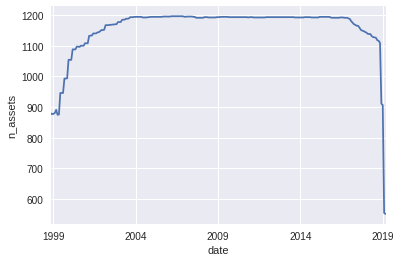

In [ ]:
data.groupby('date')['stock_id'].count().plot(ylabel='n_assets');

In [ ]:
features = data.columns.to_list()[2:-4]
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

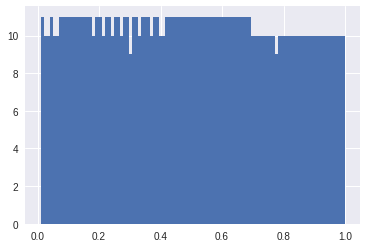

In [ ]:
data.loc[(data['date']=='2000-2-29'),'Div_Yld'].hist(bins=100);

In [ ]:
data['R1M_Usd_C'] = data.groupby('date')['R1M_Usd'].apply(lambda x: (x > x.median()))
data['R12M_Usd_C'] = data.groupby('date')['R12M_Usd'].apply(lambda x: (x > x.median()))

In [ ]:
separation_date = '2014-1-15'
separation_mask = (data['date'] < separation_date)

training_sample = data.loc[separation_mask]
testing_sample = data.loc[~separation_mask]

In [ ]:
stock_ids = data['stock_id'].unique().tolist()

max_dates = data.groupby('stock_id')['date'].count().max()
stocks_with_max_dates = data.groupby('stock_id')['date'].count() == max_dates
stock_ids_short = stocks_with_max_dates.where(stocks_with_max_dates).dropna().index.tolist()

returns = data[data['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns.pivot(index='date',columns='stock_id');

### **Chapter 2.** Introduction

There is no code in this section :)

### **Chapter 3.** Factor investing and asset pricing


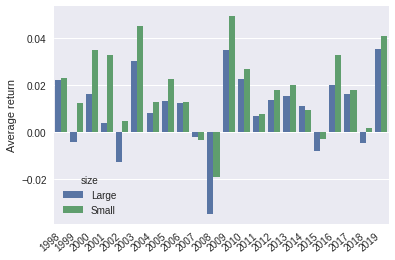

In [ ]:
data['size'] = data.groupby('date')['Mkt_Cap_12M_Usd'].apply(lambda x: (x > x.median())).replace({True:'Large',False:'Small'})
data['year'] = data['date'].dt.year


return_by_size = data.groupby(['year','size'])['R1M_Usd'].mean().reset_index()

ax = sns.barplot(x='year',y='R1M_Usd',hue='size',data=return_by_size)
ax.set(xlabel = '', ylabel = 'Average return');
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

In [ ]:
ff_url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip'

ff_factors = pd.read_csv(ff_url, compression='zip', skiprows=3)
ff_factors.rename({'Unnamed: 0':'date','Mkt-RF':'MKT_RF'}, axis = 1, inplace=True)
ff_factors = ff_factors.loc[ff_factors['date'].str.strip(' ').str.len() == 6]

def last_day_of_month(date_value):
    return date_value.replace(day = monthrange(date_value.year, date_value.month)[1])

ff_factors['date'] = pd.to_datetime(ff_factors['date'], format = '%Y%m').apply(last_day_of_month)
ff_factors[ff_factors.columns[1:]] = ff_factors[ff_factors.columns[1:]].apply(pd.to_numeric) / 100

ff_factors.head()

,date,MKT_RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.0039,-0.0047,-0.0083,0.0066,-0.0115,0.0027
1,1963-08-31,0.0507,-0.0079,0.0167,0.0040,-0.0040,0.0025
2,1963-09-30,-0.0157,-0.0048,0.0018,-0.0076,0.0024,0.0027
3,1963-10-31,0.0253,-0.0129,-0.0010,0.0275,-0.0224,0.0029
4,1963-11-30,-0.0085,-0.0084,0.0171,-0.0045,0.0222,0.0027


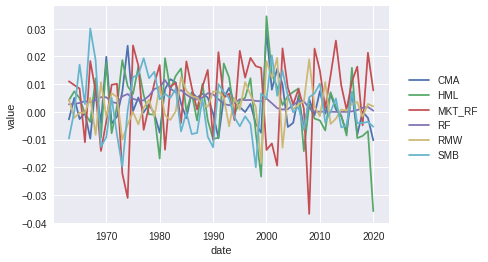

In [ ]:
temp_factors = ff_factors.copy()

temp_factors['date'] = temp_factors['date'].dt.year
temp_factors = pd.melt(temp_factors, id_vars = 'date')
temp_factors = temp_factors.groupby(['date','variable']).mean().reset_index()

plt = sns.lineplot(x='date',y='value',hue='variable', data = temp_factors);
plt.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.);

In [ ]:
data_fm = data[['date','stock_id','R1M_Usd']][data['stock_id'].isin(stock_ids_short)]
data_fm = data_fm.merge(ff_factors, on = 'date')
data_fm['R1M_Usd'] = data_fm.groupby('stock_id')['R1M_Usd'].shift(1)
data_fm.dropna(inplace=True)

reg_output = {}

for k,g in data_fm.groupby('stock_id'):
  model = ols('R1M_Usd ~ MKT_RF + SMB + HML + RMW + CMA', data=g)
  results = model.fit()

  reg_output[k] = results.params

betas = pd.DataFrame.from_dict(reg_output).T
betas.head()

,Intercept,MKT_RF,SMB,HML,RMW,CMA
3,-0.002199,0.863586,0.854215,0.758393,0.329406,-0.311581
4,0.003505,0.287847,0.328209,-0.132097,0.633425,0.400106
7,0.006208,0.366472,0.654598,0.237522,0.254661,0.138960
9,0.003232,0.842933,0.597168,1.059787,0.105530,0.100131
16,0.000242,1.196296,-0.146556,1.368709,0.117613,-0.356474


In [ ]:
loadings = betas.drop('Intercept', axis = 1).reset_index(drop=True)
ret = returns.T.reset_index(drop=True)
fm_data = pd.concat([loadings,ret], axis=1)
fm_data = pd.melt(fm_data,id_vars=['MKT_RF','SMB','HML','RMW','CMA'])

reg_output_2 = {}

for k,g in fm_data.groupby('variable'):
  model = ols('value ~ MKT_RF + SMB + HML + RMW + CMA', data=g)
  results = model.fit()

  reg_output_2[k] = results.params

gammas = pd.DataFrame.from_dict(reg_output_2).T.reset_index().rename({'index':'date'}, axis = 1)
gammas.head()

,date,Intercept,MKT_RF,SMB,HML,RMW,CMA
0,1998-11-30,0.021853,0.080532,-0.033744,-0.049524,-0.022079,-0.040940
1,1998-12-31,0.012293,0.021495,0.001923,-0.044976,-0.055633,-0.058189
2,1999-01-31,-0.026754,-0.043608,-0.014523,0.035706,0.009913,0.034615
3,1999-02-28,-0.035112,0.046851,-0.020881,0.000626,-0.019017,-0.014023
4,1999-03-31,-0.001554,0.096095,0.007455,-0.000024,-0.024633,-0.018626


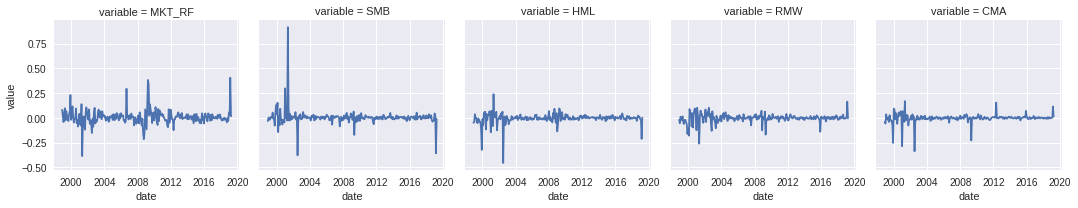

In [ ]:
x = pd.melt(gammas.drop('Intercept',axis=1), id_vars='date')

g = sns.FacetGrid(x, col='variable');
g.map(sns.lineplot, 'date', 'value');

In [ ]:
factor_comp = pd.melt(ff_factors.drop('RF',axis=1),id_vars='date')

factor_comp = factor_comp.merge(ff_factors.drop('RF',axis=1), on = 'date')

factor_comp_coefs = {}
factor_comp_tstats = {}

for k,g in factor_comp.groupby('variable'):

  reg_data = g.drop([k,'date','variable'],axis=1)
  formula = 'value ~ ' + ' + '.join(reg_data.columns.values[1:].tolist())
  
  model = ols(formula, data=reg_data)
  results = model.fit()

  factor_comp_coefs[k] = results.params
  factor_comp_tstats[k] = results.tvalues

alphas = pd.DataFrame.from_dict(factor_comp_coefs).T
alphas_tstats = pd.DataFrame.from_dict(factor_comp_tstats).T

alphas_tstats

,CMA,HML,Intercept,MKT_RF,RMW,SMB
CMA,NaN,23.849999,4.612722,-8.804987,-5.212819,-2.149754
HML,23.849999,NaN,-1.010270,1.639452,4.432026,2.289290
MKT_RF,-8.804987,1.639452,5.012853,NaN,-4.161605,5.297635
RMW,-5.212819,4.432026,4.880946,-4.161605,NaN,-8.484421
SMB,-2.149754,2.289290,2.384142,5.297635,-8.484421,NaN


In [ ]:
alphas_table = alphas.round(3).applymap(str)

prob99 = 2.58
prob95 = 1.96

alphas_table[alphas_tstats >= prob99] = alphas_table[alphas_tstats >= prob99] + ' (**)'
alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] = alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] + ' (*)'

factors = factor_comp.columns[3:].tolist()

alphas_table = alphas_table[['Intercept'] + factors].reindex(factors)

alphas_table

,Intercept,MKT_RF,SMB,HML,RMW,CMA
MKT_RF,0.008 (**),nan,0.283 (**),0.119,-0.311,-0.925
SMB,0.003 (*),0.139 (**),nan,0.116 (*),-0.428,-0.167
HML,-0.001,0.033,0.066 (*),nan,0.174 (**),1.029 (**)
RMW,0.004 (**),-0.08,-0.223,0.161 (**),nan,-0.287
CMA,0.002 (**),-0.11,-0.04,0.442 (**),-0.133,nan


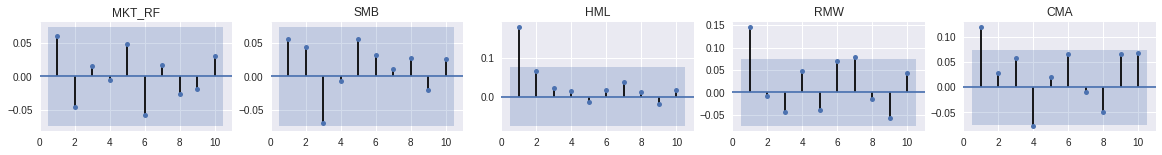

In [ ]:
nfactors = len(factors)

fig, axs = plt.subplots(ncols=nfactors, figsize = (20,2))

for i, factor in enumerate(factors):
  plot_pacf(ff_factors[factor], ax = axs[i], lags = 10, zero = False, title = factor);

### **Chapter 4.** Data preprocessing

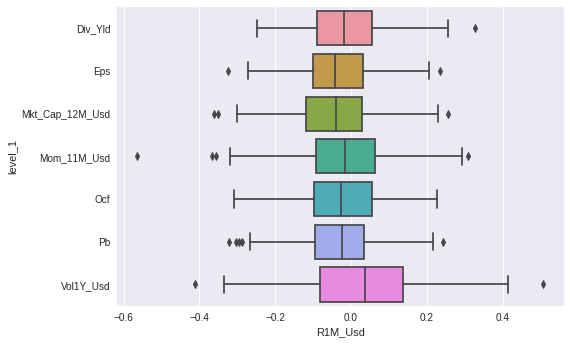

In [ ]:
cols_to_keep = features_short+['R1M_Usd','date']
corr_data = data[cols_to_keep]
corr_data = corr_data.groupby('date').corr()[['R1M_Usd']].reset_index()
corr_data = corr_data.loc[corr_data['level_1']!='R1M_Usd']

sns.boxplot(x='R1M_Usd',y='level_1', data = corr_data);

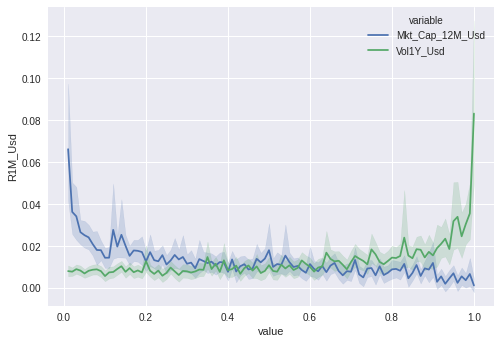

In [ ]:
x = pd.melt(data[['R1M_Usd','Mkt_Cap_12M_Usd','Vol1Y_Usd']], id_vars='R1M_Usd')

sns.lineplot(data = x, y='R1M_Usd', x='value', hue='variable');

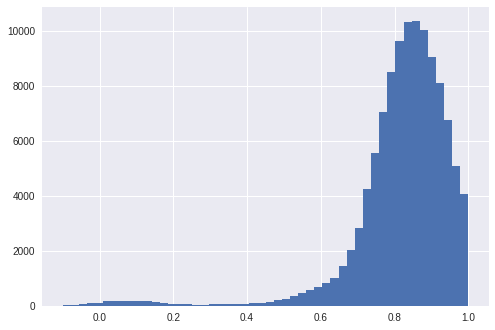

In [ ]:
cols_to_keep = ['stock_id'] + features

pd.melt(data[cols_to_keep], id_vars='stock_id').groupby(['stock_id','variable']).apply(lambda x: x['value'].autocorr(lag=1)).hist(bins=50,range=[-0.1,1]);

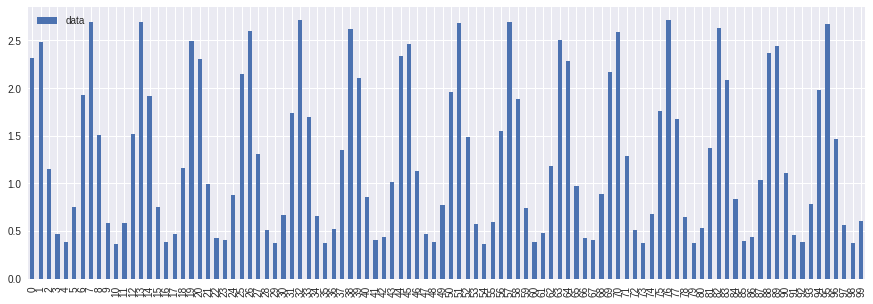

In [ ]:
length = 100
x = np.exp(np.sin(np.linspace(1,length,length)))
df = pd.DataFrame(data=x,columns=['data'])

df.plot(kind='bar', figsize=(15,5));

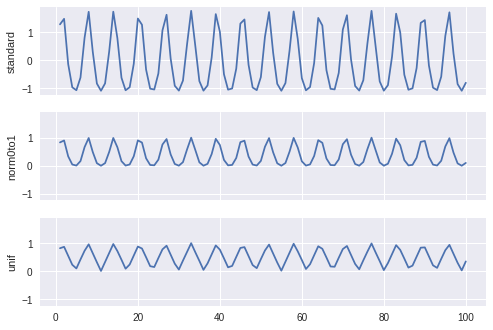

In [ ]:
def norm_0to1(x):
  return ((x-np.min(x))/(np.max(x)-np.min(x)))

df = pd.DataFrame.from_dict(dict(
    index = np.linspace(1,length,length),
    standard = (x - np.mean(x))/np.std(x),
    norm0to1 = norm_0to1(x),
    unif = ECDF(x)(x)
))

fig, axs = plt.subplots(3, sharex=True, sharey=True)
for i, col in enumerate(df.columns[1:]):
  axs[i].plot(df['index'],df[col])
  axs[i].set_ylabel(col)

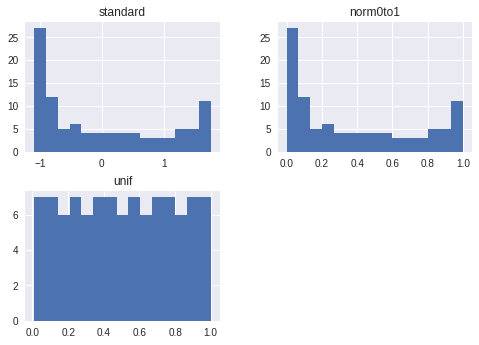

In [ ]:
df.drop('index',axis=1).hist(bins=15);

### **Chapter 5.** Penalized regressions and sparse hedging for minimum variance portfolios